In [74]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import pandas as pd
from typing import Callable
import os


pd.options.display.max_columns = 21
pd.options.display.float_format = '{:.2f}'.format

### Paramètres

In [75]:
Card = int
Action = int
Hand = tuple[int, int, int, int, int, int, int, int, int, int, int, int, int]
Policy = Callable[[Hand, Hand], Action]
PlayerPolicy = Callable[[Hand, Card], Action]


ACE: Card = 1
TWO: Card = 2
THREE: Card = 3
FOUR: Card = 4
FIVE: Card = 5
SIX: Card = 6
SEVEN: Card = 7
EIGHT: Card = 8
NINE: Card = 9
TEN: Card = 10
JACK: Card = 10
QUEEN: Card = 10
KING: Card = 10

card_values: list[Card] = [ACE, TWO, THREE, FOUR, FIVE, SIX, SEVEN, EIGHT, NINE, TEN, JACK, QUEEN, KING]
num_cards: int = len(card_values)
cards: list[int] = list(range(num_cards))

max_card_value: int = max(card_values)
max_score: int = 21

In [76]:
HIT: Action = 0
STAND: Action = 1
DOUBLE: Action = 2
SPLIT: Action = 3
SURRENDER: Action = 4

actions_str: dict[Action, str] = {
    HIT: 'Hit',
	STAND: 'Stand',
	DOUBLE: 'Double',
	SPLIT: 'Split',
	SURRENDER: 'Surrender',
}

actions_color: dict[Action, str] = {
    HIT: 'lightgreen',
	STAND: 'indianred',
	DOUBLE: 'lightblue',
	SPLIT: 'khaki',
	SURRENDER: 'orange',
}

In [77]:
def probaDraw(card: Card) -> float:
	"""
	Probability of hitting a given card
	"""
	return 1 / num_cards

In [78]:
def countScore(ace=0, two=0, three=0, four=0, five=0, six=0, seven=0, eight=0, nine=0, ten=0, jack=0, queen=0, king=0) -> int:
	"""
	Score of some cards
	Each ace is counted as 11 if the total score is less than or equal to 21, otherwise it is counted as 1
	"""
	score = 0
	score += ace * ACE
	score += two * TWO
	score += three * THREE
	score += four * FOUR
	score += five * FIVE
	score += six * SIX
	score += seven * SEVEN
	score += eight * EIGHT
	score += nine * NINE
	score += ten * TEN
	score += jack * JACK
	score += queen * QUEEN
	score += king * KING
	while score <= max_score -10 and ace > 0:
		score += 10
		ace -= 1
	return score

def minScore(ace=0, two=0, three=0, four=0, five=0, six=0, seven=0, eight=0, nine=0, ten=0, jack=0, queen=0, king=0) -> int:
	"""
	Minimum possible score of some cards
	Each ace is counted as 1
	"""
	return ace + countScore(ace=0, two=two, three=three, four=four, five=five, six=six, seven=seven, eight=eight, nine=nine, ten=ten, jack=jack, queen=queen, king=king)

def handScore(hand: Hand) -> int:
	"""
	Score of a hand
	Each ace is counted as 11 if the total score is less than or equal to 21, otherwise it is counted as 1
	"""	
	return countScore(*hand)

def minHandScore(hand: Hand) -> int:
	"""
	Minimum possible score of a Hand
	Each ace is counted as 1
	"""
	return minScore(*hand)

def haveAce11(hand: Hand) -> bool:
	"""
	Do we have an ace counted as 11 in a Hand
	"""
	return minHandScore(hand) != handScore(hand)

Maintenant on peut générer l'ensemble des mains valides  
On considère toutes les mains possibles dont le score est inférieur à 21  
Il faut noter que la main vide et les mains d'une seule carte sont considérées comme valides

In [79]:
valid_hands_to_index: dict[Hand, int] = {}
idx = 0
for ace in range(0, max_score+1):
	score = minScore(ace)
	for two in range(0, (max_score-score) // TWO +1):
		score = minScore(ace, two)
		for three in range(0, (max_score-score) // THREE +1):
			score = minScore(ace, two, three)
			for four in range(0, (max_score-score) // FOUR +1):
				score = minScore(ace, two, three, four)
				for five in range(0, (max_score-score) // FIVE +1):
					score = minScore(ace, two, three, four, five)
					for six in range(0, (max_score-score) // SIX +1):
						score = minScore(ace, two, three, four, five, six)
						for seven in range(0, (max_score-score) // SEVEN +1):
							score = minScore(ace, two, three, four, five, six, seven)
							for eight in range(0, (max_score-score) // EIGHT +1):
								score = minScore(ace, two, three, four, five, six, seven, eight)
								for nine in range(0, (max_score-score) // NINE +1):
									score = minScore(ace, two, three, four, five, six, seven, eight, nine)
									for ten in range(0, (max_score-score) // TEN +1):
										score = minScore(ace, two, three, four, five, six, seven, eight, nine, ten)
										for jack in range(0, (max_score-score) // JACK +1):
											score = minScore(ace, two, three, four, five, six, seven, eight, nine, ten, jack)
											for queen in range(0, (max_score-score) // QUEEN +1):
												score = minScore(ace, two, three, four, five, six, seven, eight, nine, ten, jack, queen)
												for king in range(0, (max_score-score) // KING +1):
													score = countScore(ace, two, three, four, five, six, seven, eight, nine, ten, jack, queen, king)
													if score <= max_score:
														valid_hands_to_index[(ace, two, three, four, five, six, seven, eight, nine, ten, jack, queen, king)] = idx
														idx += 1
              
num_hands = len(valid_hands_to_index)
index_to_valid_hands: list[Hand] = [None] * num_hands
for hand, idx in valid_hands_to_index.items():
	index_to_valid_hands[idx] = hand

print(f"Number of valid hands: {num_hands}")

Number of valid hands: 3677


Nous allons avoir besoin de fonctions classiques pour créer et agrandir une main

In [80]:
def createHand(*args: Card) -> Hand:
	"""
	Create a hand from a list of cards
	Note that 0 correspond to an ace, 1 to a two, 2 to a three, ..., 9 to a ten, 10 to a jack, 11 to a queen and 12 to a king
	"""
	hand = [0] * num_cards
	for card in args:
		hand[card] += 1
	return tuple(hand)

def addCard(hand: Hand, card: Card) -> Hand:
	"""
	Add a card to a hand
	"""
	hand = list(hand)
	hand[card] += 1
	return tuple(hand)

Des fonctions pour comparer les valeurs des mains, notamment avec la présence de BlackJack nous sont aussi utiles

In [81]:
def checkBlackjack(hand: Hand, score=None) -> bool:
	"""
	Check if a hand is a blackjack
	Score is the score of the hand if it is already computed
	"""
	score = score or handScore(hand)
	return handScore(hand) == max_score and sum(hand) == 2

def couldBlackJack(hand: Hand) -> bool:
	"""
	Check if a hand could be a blackjack
	"""
	match sum(hand):
		case 0:
			return True
		case 1:
			return hand[0] == 1 or hand[9] == 1 or hand[10] == 1 or hand[11] == 1 or hand[12] == 1
		case 2:
			return handScore(hand) == max_score
		case _:
			return False

def handComparisonDealerPOV(dealer_hand: Hand, player_hand: Hand) -> float:
	"""
	Compare two valid hands
	Return 1 if the dealer wins, 0 if it is a draw and -1 if the player wins
	Check if there is a blackjack for the dealer and the player
	"""
	sd = handScore(dealer_hand)
	sp = handScore(player_hand)
	dealer_blackjack = checkBlackjack(dealer_hand, sd)
	player_blackjack = checkBlackjack(player_hand, sp)
	if dealer_blackjack and player_blackjack:
		return 0
	elif dealer_blackjack:
		return 1
	elif player_blackjack:
		return -1.5
	elif sd > sp:
		return 1
	elif sd < sp:
		return -1
	else:
		return 0
 

#### Calcul de la politique optimale du joueur

In [82]:
def probaHit(hand: hand) -> float:
	"""
	Probability of hitting and not bursting
	"""
	return sum(probaDraw(card) for card in cards if addCard(hand, card) in valid_hands_to_index)

def probaHitList(hand: hand) -> list[hand, float]:
	"""
	Compute the score and the probability of hitting for each card that do not burst the score
	"""
	return [(addCard(hand, card), probaDraw(card)) for card in cards if addCard(hand, card) in valid_hands_to_index]

In [83]:
def probaBurst(hand: hand) -> float:
	"""
	Probability of bursting
	"""
	return 1 - probaHit(hand)

def probaBurstList(hand: hand) -> list[hand, float]:
	"""
	Compute the score and the probability of bursting for each card that burst the score
	"""
	return [(addCard(hand, card), probaDraw(card)) for card in cards if addCard(hand, card) not in valid_hands_to_index]

In [84]:
def getDealerGainMatrixOptimalPolicy() -> tuple[np.ndarray, np.ndarray]:
	"""
	Compute the gain matrix for the dealer optimal policy
	It consider that only 2 actions are possible: hit or stand
	The dealer policy matrix is also computed and returned
	"""
	gainMatrix = np.zeros((num_hands, num_hands))
	policyMatrix = np.zeros((num_hands, num_hands))
	for hand_player_idx in range(num_hands):
		hand_player = index_to_valid_hands[hand_player_idx]
		for hand_dealer_idx in range(num_hands-1, -1, -1):
			hand_dealer = index_to_valid_hands[hand_dealer_idx]

			hit_score = 0
			for new_hand, proba in probaHitList(hand_dealer):
				hit_score += proba * gainMatrix[hand_player_idx, valid_hands_to_index[new_hand]]
			hit_score -= probaBurst(hand_dealer)
			stand_score = handComparisonDealerPOV(hand_dealer, hand_player)
   
			if stand_score == -1.5 and not couldBlackJack(hand_dealer):
				gainMatrix[hand_player_idx, hand_dealer_idx] = -1.5
				policyMatrix[hand_player_idx, hand_dealer_idx] = STAND
			else:
				gainMatrix[hand_player_idx, hand_dealer_idx] = max(hit_score, stand_score)
				policyMatrix[hand_player_idx, hand_dealer_idx] = HIT if hit_score > stand_score else STAND
	return gainMatrix, policyMatrix

In [85]:
def getDealerGainMatrixFromPolicy(policy: Policy) -> tuple[np.ndarray, np.ndarray]:
	"""
	Compute the gain matrix for a given policy
	It consider that only 2 actions are possible: hit or stand
	The dealer policy matrix is also computed and returned
	"""
	gainMatrix = np.zeros((num_hands, num_hands))
	policyMatrix = np.zeros((num_hands, num_hands))
	for hand_player_idx in range(num_hands):
		hand_player = index_to_valid_hands[hand_player_idx]
		for hand_dealer_idx in range(num_hands-1, -1, -1):
			hand_dealer = index_to_valid_hands[hand_dealer_idx]
			action = policy(hand_player, hand_dealer)
			if action == HIT:
				for new_hand, proba in probaHitList(hand_dealer):
					gainMatrix[hand_player_idx, hand_dealer_idx] += proba * gainMatrix[hand_player_idx, valid_hands_to_index[new_hand]]
				gainMatrix[hand_player_idx, hand_dealer_idx] -= probaBurst(hand_dealer)
			elif action == STAND:
				gainMatrix[hand_player_idx, hand_dealer_idx] = handComparisonDealerPOV(hand_dealer, hand_player)
			policyMatrix[hand_player_idx, hand_dealer_idx] = action
	return gainMatrix, policyMatrix

In [86]:
def standOn17Hard(player_hand: Hand, dealer_hand: Hand) -> Action:
	"""
	Dealer stand on 17 hard
	"""
	return STAND if handScore(dealer_hand) >= 17 else HIT

In [87]:
def standOn17Soft(player_hand: Hand, dealer_hand: Hand) -> Action:
	"""
	Dealer stand on 17 soft
	"""
	return HIT if handScore(dealer_hand) < 17 or (haveAce11(dealer_hand) and handScore(dealer_hand) == 17) else STAND

In [88]:
compute = False
if compute:
	dealerGainOptimal, dealerPolicyOptimal = getDealerGainMatrixOptimalPolicy()
	print("Optimal policy computed")
	dealerGain17Hard, dealerPolicy17Hard = getDealerGainMatrixFromPolicy(standOn17Hard)
	print("Dealer stand on 17 hard policy computed")
	dealerGain17Soft, dealerPolicy17Soft = getDealerGainMatrixFromPolicy(standOn17Soft)
	print("Dealer stand on 17 soft policy computed")
else:
    dealerGainOptimal = np.load("data/dealerGainOptimal.npy")
    dealerPolicyOptimal = np.load("data/dealerPolicyOptimal.npy")
    dealerGain17Hard = np.load("data/dealerGain17Hard.npy")
    dealerPolicy17Hard = np.load("data/dealerPolicy17Hard.npy")
    dealerGain17Soft = np.load("data/dealerGain17Soft.npy")
    dealerPolicy17Soft = np.load("data/dealerPolicy17Soft.npy")
    

In [89]:
save = True
if save:
    if not os.path.exists("data"):
        os.makedirs("data")
    np.save("data/dealerGainOptimal.npy", dealerGainOptimal)
    np.save("data/dealerPolicyOptimal.npy", dealerPolicyOptimal)
    np.save("data/dealerGain17Hard.npy", dealerGain17Hard)
    np.save("data/dealerPolicy17Hard.npy", dealerPolicy17Hard)
    np.save("data/dealerGain17Soft.npy", dealerGain17Soft)
    np.save("data/dealerPolicy17Soft.npy", dealerPolicy17Soft)

In [90]:
check = False
if check:
	dealerOptimal = np.load("data/dealerGainOptimal.npy")
	dealer17Hard = np.load("data/dealerGain17Hard.npy")
	dealer17Soft = np.load("data/dealerGain17Soft.npy")
	assert np.allclose(dealerOptimal, dealerGainOptimal)
	assert np.allclose(dealer17Hard, dealerGain17Hard)
	assert np.allclose(dealer17Soft, dealerGain17Soft)

#### Calcul de la politique optimale du joueur

In [91]:
def getPlayerGainMatrixOptimalPolicy(dealerGainMatrix: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
	"""
	Compute the gain matrix for the player optimal policy
	It consider that 2 actions are possible: hit or stand
	The player policy matrix is also computed and returned
	"""
	gainMatrix = np.zeros((num_hands, 13))
	policyMatrix = np.zeros((num_hands, 13))
	for hand_player_idx in range(num_hands-1, -1, -1):
		hand_player = index_to_valid_hands[hand_player_idx]
		for card_dealer in range(num_cards):
			hand_dealer = createHand(card_dealer)
			hand_dealer_idx = valid_hands_to_index[hand_dealer]
   
			hit_score = 0
			for new_hand, proba in probaHitList(hand_player):
				hit_score += proba * gainMatrix[valid_hands_to_index[new_hand], card_dealer]
			hit_score -= probaBurst(hand_player)
			stand_score = -dealerGainMatrix[hand_player_idx, hand_dealer_idx]
   
			gainMatrix[hand_player_idx, card_dealer] = max(hit_score, stand_score)
			policyMatrix[hand_player_idx, card_dealer] = HIT if hit_score >= stand_score else STAND
	return gainMatrix, policyMatrix

In [92]:
playerGainOptimal, playerOptimalPolicyMatrix = getPlayerGainMatrixOptimalPolicy(dealerGainOptimal)

A présent on aimerait vérifier que nos résultats sont cohérents  
Notre première idée est de vérifier que pour un score égal, et un nombre d'ace valant 11 égal, on ait les mêmes probabilités de victoire contre le croupier

In [93]:
def checkPlayerGainMatrix(playerGainMatrix: np.ndarray) -> bool:
	"""
	Check if the player gain matrix is the same for equivalent hands
	"""
	for hand1, hand1_idx in valid_hands_to_index.items():
		for hand2, hand2_idx in valid_hands_to_index.items():
			s1 = handScore(hand1)
			s2 = handScore(hand2)
			if s1 == s2 and couldBlackJack(hand1) == couldBlackJack(hand2) and haveAce11(hand1) == haveAce11(hand2):
				assert np.allclose(playerGainMatrix[hand1_idx], playerGainMatrix[hand2_idx])

In [94]:
check_matrices = False
if check_matrices:
	checkPlayerGainMatrix(playerGainOptimal)

On peut maintenant ajouter de nouvelles actions possibles pour le joueur: DOUBLE, SPLIT, SURRENDER

In [95]:
def updatePolicyDouble(dealerGainMatrix: np.ndarray, playerGainMatrix: np.ndarray, playerPolicy: np.ndarray, in_place=True) -> tuple[np.ndarray, np.ndarray]:
	"""
	Update the player policy with the double action
	"""
	gainMatrix = playerGainMatrix if in_place else playerGainMatrix.copy()
	policy = playerPolicy if in_place else playerPolicy.copy()
	for card1 in cards:
		for card2 in cards:
			for card_dealer in cards:
				hand_player = createHand(card1, card2)
				hand_player_idx = valid_hands_to_index[hand_player]
    
				double_score = 0
				for new_hand, proba in probaHitList(hand_player):
					double_score -= proba * dealerGainMatrix[valid_hands_to_index[new_hand], valid_hands_to_index[createHand(card_dealer)]]
				double_score -= probaBurst(hand_player)
				double_score *= 2
				if double_score >= playerGainMatrix[hand_player_idx, card_dealer]:
					gainMatrix[hand_player_idx, card_dealer] = double_score
					policy[hand_player_idx, card_dealer] = DOUBLE
	return gainMatrix, policy

In [96]:
def updatePolicySplit(playerGainMatrix: np.ndarray, playerPolicyMatrix: np.ndarray, in_place:bool=True) -> tuple[np.ndarray, np.ndarray]:
	"""
	Update the player policy with the split action
	"""
	gainMatrix = playerGainMatrix if in_place else playerGainMatrix.copy()
	policyMatrix = playerPolicyMatrix if in_place else playerPolicyMatrix.copy()
	for card_1 in cards:
		for card_dealer in cards:
			hand_player_pair = createHand(card_1, card_1)
			hand_player_single = createHand(card_1)
			score_split = 2 * gainMatrix[valid_hands_to_index[hand_player_single], card_dealer]
			if score_split >= gainMatrix[valid_hands_to_index[hand_player_pair], card_dealer]:
				gainMatrix[valid_hands_to_index[hand_player_pair], card_dealer] = score_split
				policyMatrix[valid_hands_to_index[hand_player_pair], card_dealer] = SPLIT
	return gainMatrix, policyMatrix

In [97]:
def updatePolicySurrender(playerGainMatrix: np.ndarray, playerPolicyMatrix: np.ndarray, in_place:bool=True) -> tuple[np.ndarray, np.ndarray]:
	"""
	Update the player policy with the surrender action
	"""
	gainMatrix = playerGainMatrix if in_place else playerGainMatrix.copy()
	policyMatrix = playerPolicyMatrix if in_place else playerPolicyMatrix.copy()
	for card1 in cards:
		for card2 in cards:
			for card_dealer in cards:
				hand_player = createHand(card1, card2)
				hand_player_idx = valid_hands_to_index[hand_player]
	
				surrender_score = -0.5
				if surrender_score >= playerGainMatrix[hand_player_idx, card_dealer]:
					gainMatrix[hand_player_idx, card_dealer] = surrender_score
					policyMatrix[hand_player_idx, card_dealer] = SURRENDER
	return gainMatrix, policyMatrix

In [98]:
def getPlayerGainMatrixMultiActions(dealerGainMatrix: np.ndarray, double:bool = True, split: bool = True, surrender: bool = True) -> tuple[np.ndarray, np.ndarray]:
	"""
	Compute the gain matrix for the player optimal policy with more actions
	"""
	playerGainMatrix, playerPolicyMatrix = getPlayerGainMatrixOptimalPolicy(dealerGainMatrix)
	if double:
		updatePolicyDouble(dealerGainMatrix, playerGainMatrix, playerPolicyMatrix, in_place=True)
	if split:
		updatePolicySplit(playerGainMatrix, playerPolicyMatrix, in_place=True)
	if surrender:
		updatePolicySurrender(playerGainMatrix, playerPolicyMatrix, in_place=True)
	return playerGainMatrix, playerPolicyMatrix

In [99]:
split = True
double = True
surrender = True
playerGainOptimalMulti, playerPolicyOptimalMulti = getPlayerGainMatrixMultiActions(dealerGainOptimal, split, double, surrender)
playerGainOptimalMulti17Hard, playerPolicyOptimalMulti17Hard = getPlayerGainMatrixMultiActions(dealerGain17Hard, split, double, surrender)
playerGainOptimalMulti17Soft, playerPolicyOptimalMulti17Soft = getPlayerGainMatrixMultiActions(dealerGain17Soft, split, double, surrender)

In [100]:
def plot_single_policy_matrix(policy_matrix, title=None, ax=None, cmap=None, norm=None, plot_legend=True, xlegend=None, ylegend=None, xcard=False, ycard=False,  xlegend_dec=0, ylegend_dec=0, xlegend_dec_end=0, ylegend_dec_end=0):
    xlabel = np.arange(1 + xlegend_dec, policy_matrix.shape[1] + 1 + xlegend_dec, 1) if not xcard else ["2", "3", "4", "5", "6", "7", "8", "9", "10", "V", "D", "R", "A"]
    ylabel = np.arange(1 + ylegend_dec, policy_matrix.shape[0] + 1 + ylegend_dec, 1) if not ycard else ["2", "3", "4", "5", "6", "7", "8", "9", "10", "V", "D", "R", "A"]
    if xlegend_dec != 0 and xcard:
        xlabel = xlabel[xlegend_dec:policy_matrix.shape[1]+xlegend_dec]
    if ylegend_dec != 0 and ycard:
        ylabel = ylabel[ylegend_dec:policy_matrix.shape[0]+ylegend_dec]
    if xlegend_dec_end	!= 0 and xcard:
        xlabel = xlabel[-policy_matrix.shape[1]-xlegend_dec_end:-xlegend_dec_end]
    if ylegend_dec_end	!= 0 and ycard:
        ylabel = ylabel[-policy_matrix.shape[0]-ylegend_dec_end:-ylegend_dec_end]
    xlegend = xlegend if xlegend is not None else "Dealer Card Value"
    ylegend = ylegend if ylegend is not None else "Player Score"
    unique_values = sorted(set(val for val in np.unique(policy_matrix) if not np.isnan(val)))
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 10))
    else:
        fig = ax.figure 
    
    cmap = cmap if cmap is not None else mcolors.ListedColormap([actions_color[action] for action in unique_values])    
    norm = norm if norm is not None else mcolors.BoundaryNorm(boundaries=np.linspace(min(unique_values) - 0.5, max(unique_values) + 0.5, len(unique_values) + 1), ncolors=len(unique_values))
    im = ax.imshow(policy_matrix, cmap=cmap, norm=norm, aspect="auto", origin="lower")
    if title:
        ax.set_title(title, fontsize=14, pad=20)
    
    ax.set_xticks(np.arange(0, policy_matrix.shape[1]))
    ax.set_yticks(np.arange(0, policy_matrix.shape[0]))
    ax.set_xticklabels(xlabel)
    ax.set_yticklabels(ylabel)
    ax.set_xlabel(xlegend, fontsize=12, labelpad=15)
    ax.set_ylabel(ylegend, fontsize=12, labelpad=15)
    ax.set_xticks(np.arange(-.5, policy_matrix.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, policy_matrix.shape[0], 1), minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    ax.tick_params(which='minor', bottom=False, left=False)
    
    if plot_legend:
        actions_str = [f"Action {int(val)}" for val in unique_values]
        legend_patches = [Patch(color=cmap(norm(val)), label=actions_str[int(val)]) for val in unique_values]
        ax.legend(handles=legend_patches, loc="upper center", ncol=len(unique_values), 
                  frameon=False, fontsize=12, handlelength=2, handletextpad=1, bbox_to_anchor=(0.5, 1.1))
        fig.subplots_adjust(top=0.85)
    
    return im


def plot_policy_matrices(policyMatrices, options=None, save=False, filename=None):
    options = options or {}
    num_matrices = len(policyMatrices)
    fig, axes = plt.subplots(1, num_matrices, figsize=(5 * num_matrices, 10))
    if num_matrices == 1:
        axes = [axes]
    all_unique_values = sorted(set(val for matrix in policyMatrices for val in np.unique(matrix) if not np.isnan(val)))

    cmap = mcolors.ListedColormap([actions_color[action] for action in all_unique_values])
    norm = mcolors.BoundaryNorm(boundaries=np.arange(len(all_unique_values) + 1) - 0.5, ncolors=len(all_unique_values))
    
    for i, (policy, options) in enumerate(zip(policyMatrices, options)):
        plot_single_policy_matrix(policy, ax=axes[i], cmap=cmap, norm=norm, plot_legend=False, **options)
    
    legend_patches = [Patch(color=cmap(i / max(len(all_unique_values) - 1, 1)), label=actions_str[int(val)])
                      for i, val in enumerate(all_unique_values)]
    fig.legend(handles=legend_patches, loc="upper center", ncol=len(all_unique_values),
               frameon=False, fontsize=14, handlelength=2, handletextpad=1)
    if save:
        plt.savefig(filename if filename is not None else "policy_matrices.png", bbox_inches="tight")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [101]:
def plot_policy_results(policyMatrix: np.ndarray, save: bool = False, filename: str = ""):
	policyMismatch = np.zeros((17, 13))
	for card in card_values[1:]:
		for card_dealer in cards:
			hand_player1 = createHand(card-1, card+1)
			hand_player2 = createHand(card, card - 1)
			hand_player_idx1 = valid_hands_to_index[hand_player1]
			hand_player_idx2 = valid_hands_to_index[hand_player2]
			policyMismatch[handScore(hand_player1)-5, card_dealer-1] = policyMatrix[hand_player_idx1, card_dealer]
			policyMismatch[handScore(hand_player2)-5, card_dealer-1] = policyMatrix[hand_player_idx2, card_dealer]
	policyMismatch[21-5, :] = policyMatrix[valid_hands_to_index[createHand(7, 6, 5)], :]
	optionsMismatch = {
		"title": "Mismatched cards",
		"ylegend": "Player Score",
		"ylegend_dec": 4,
		"xcard": True,
    }
   
	policyPairs = np.zeros((13, 13))
	for card_1 in cards:
		for card_dealer in cards:
			hand_player = createHand(card_1, card_1)
			hand_player_idx = valid_hands_to_index[hand_player]
			policyPairs[card_1, card_dealer-1] = policyMatrix[hand_player_idx, card_dealer]
	policyPairs = np.roll(policyPairs, -1, axis=0)
	optionsPairs = {
		"title": "Pairs",
		"ylegend": "Card",
		"ycard": True,
		"xcard": True,
	}

	policyAs = np.zeros((12, 13))
	for card_1 in cards[1:]:
		for card_dealer in cards:
			hand_player = createHand(0, card_1)
			hand_player_idx = valid_hands_to_index[hand_player]
			policyAs[card_1-1, card_dealer] = policyMatrix[hand_player_idx, card_dealer]
	policyAs = np.roll(policyAs, -1, axis=1)
	optionsAs = {
		"title": "Ace",
		"ylegend": "Second Card",
		"ylegend_dec_end": 1,
		"ycard": True,
		"xcard": True,
	}
   
	plot_policy_matrices([policyMismatch, policyPairs, policyAs], [optionsMismatch, optionsPairs, optionsAs], save=save, filename=filename)

In [102]:
def plot_single_gain_matrix(policy_matrix, title=None, ax=None, cmap=None, norm=None, plot_legend=True, xlegend=None, ylegend=None, xcard=False, ycard=False,  xlegend_dec=0, ylegend_dec=0, xlegend_dec_end=0, ylegend_dec_end=0):
    xlabel = np.arange(1 + xlegend_dec, policy_matrix.shape[1] + 1 + xlegend_dec, 1) if not xcard else ["2", "3", "4", "5", "6", "7", "8", "9", "10", "V", "D", "R", "A"]
    ylabel = np.arange(1 + ylegend_dec, policy_matrix.shape[0] + 1 + ylegend_dec, 1) if not ycard else ["2", "3", "4", "5", "6", "7", "8", "9", "10", "V", "D", "R", "A"]
    if xlegend_dec != 0 and xcard:
        xlabel = xlabel[xlegend_dec:policy_matrix.shape[1]+xlegend_dec]
    if ylegend_dec != 0 and ycard:
        ylabel = ylabel[ylegend_dec:policy_matrix.shape[0]+ylegend_dec]
    if xlegend_dec_end	!= 0 and xcard:
        xlabel = xlabel[-policy_matrix.shape[1]-xlegend_dec_end:-xlegend_dec_end]
    if ylegend_dec_end	!= 0 and ycard:
        ylabel = ylabel[-policy_matrix.shape[0]-ylegend_dec_end:-ylegend_dec_end]
    xlegend = xlegend if xlegend is not None else "Dealer Card Value"
    ylegend = ylegend if ylegend is not None else "Player Score"
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 10))
    else:
        fig = ax.figure 
    
    cmap = cmap if cmap is not None else plt.cm.inferno 
    norm = norm if norm is not None else mcolors.Normalize(vmin=-1, vmax=1.5)
    im = ax.imshow(policy_matrix, cmap=cmap, norm=norm, aspect="auto", origin="lower")
    if title:
        ax.set_title(title, fontsize=14, pad=20)
    
    ax.set_xticks(np.arange(0, policy_matrix.shape[1]))
    ax.set_yticks(np.arange(0, policy_matrix.shape[0]))
    ax.set_xticklabels(xlabel)
    ax.set_yticklabels(ylabel)
    ax.set_xlabel(xlegend, fontsize=12, labelpad=15)
    ax.set_ylabel(ylegend, fontsize=12, labelpad=15)
    ax.set_xticks(np.arange(-.5, policy_matrix.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, policy_matrix.shape[0], 1), minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    ax.tick_params(which='minor', bottom=False, left=False)
    
    if plot_legend:
        cbar = fig.colorbar(im, ax=ax, orientation="vertical")
        cbar.set_label("Gain", fontsize=12)
        # cbar.set_ticks(np.linspace(-1, 1.5, 16)) 
        fig.subplots_adjust(top=0.85)
    
    return im


def plot_gain_matrices(policyMatrices, options=None, save=False, filename=None):
    options = options or {}
    num_matrices = len(policyMatrices)
    fig, axes = plt.subplots(1, num_matrices, figsize=(5 * num_matrices, 10))
    if num_matrices == 1:
        axes = [axes]

    cmap = plt.cm.inferno 
    norm = mcolors.Normalize(vmin=-1, vmax=1.5) 
    
    for i, (policy, options) in enumerate(zip(policyMatrices, options)):
        plot_single_gain_matrix(policy, ax=axes[i], cmap=cmap, norm=norm, plot_legend=(i == num_matrices - 1), **options)

    if save:
        plt.savefig(filename if filename is not None else "policy_matrices.png", bbox_inches="tight")
    plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1)
    plt.show()

In [103]:
def plot_gain_results(gainMatrix: np.ndarray, save: bool = False, filename: str = ""):
	policyMismatch = np.zeros((17, 13))
	for card in card_values[1:]:
		for card_dealer in cards:
			hand_player1 = createHand(card-1, card+1)
			hand_player2 = createHand(card, card - 1)
			hand_player_idx1 = valid_hands_to_index[hand_player1]
			hand_player_idx2 = valid_hands_to_index[hand_player2]
			policyMismatch[handScore(hand_player1)-5, card_dealer-1] = gainMatrix[hand_player_idx1, card_dealer]
			policyMismatch[handScore(hand_player2)-5, card_dealer-1] = gainMatrix[hand_player_idx2, card_dealer]
	policyMismatch[21-5, :] = gainMatrix[valid_hands_to_index[createHand(7, 6, 5)], :]
	optionsMismatch = {
		"title": "Mismatched cards",
		"ylegend": "Player Score",
		"ylegend_dec": 4,
		"xcard": True,
    }
   
	policyPairs = np.zeros((13, 13))
	for card_1 in cards:
		for card_dealer in cards:
			hand_player = createHand(card_1, card_1)
			hand_player_idx = valid_hands_to_index[hand_player]
			policyPairs[card_1, card_dealer-1] = gainMatrix[hand_player_idx, card_dealer]
	policyPairs = np.roll(policyPairs, -1, axis=0)
	optionsPairs = {
		"title": "Pairs",
		"ylegend": "Card",
		"ycard": True,
		"xcard": True,
	}

	policyAs = np.zeros((12, 13))
	for card_1 in cards[1:]:
		for card_dealer in cards:
			hand_player = createHand(0, card_1)
			hand_player_idx = valid_hands_to_index[hand_player]
			policyAs[card_1-1, card_dealer] = gainMatrix[hand_player_idx, card_dealer]
	policyAs = np.roll(policyAs, -1, axis=1)
	optionsAs = {
		"title": "Ace",
		"ylegend": "Second Card",
		"ylegend_dec_end": 1,
		"ycard": True,
		"xcard": True,
	}
   
	plot_gain_matrices([policyMismatch, policyPairs, policyAs], [optionsMismatch, optionsPairs, optionsAs], save=save, filename=filename)

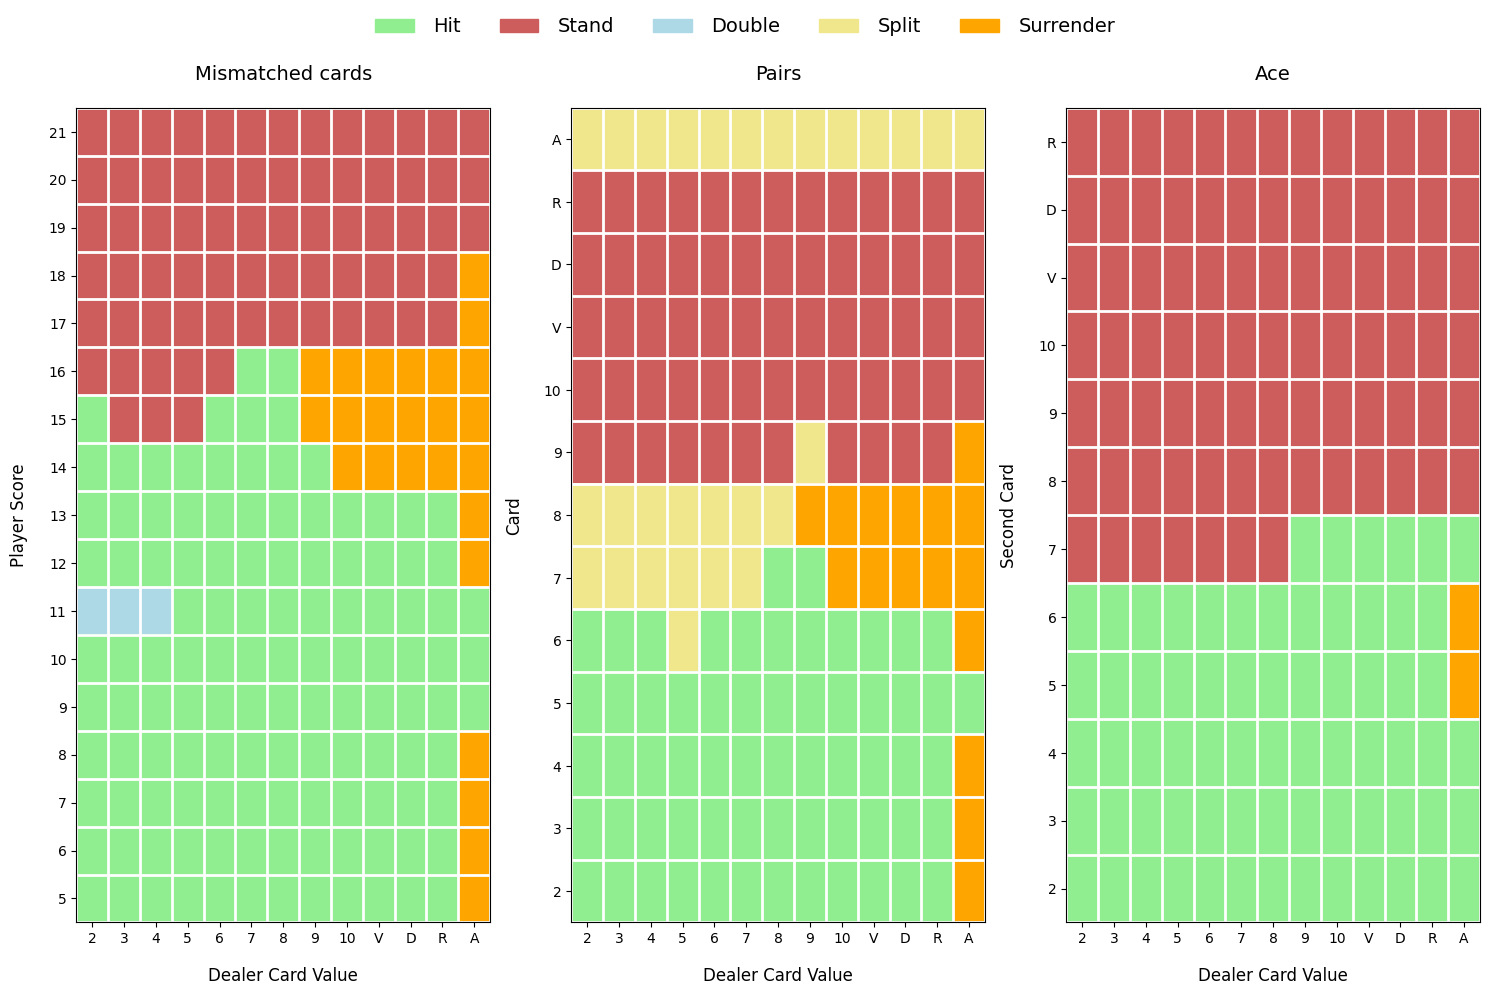

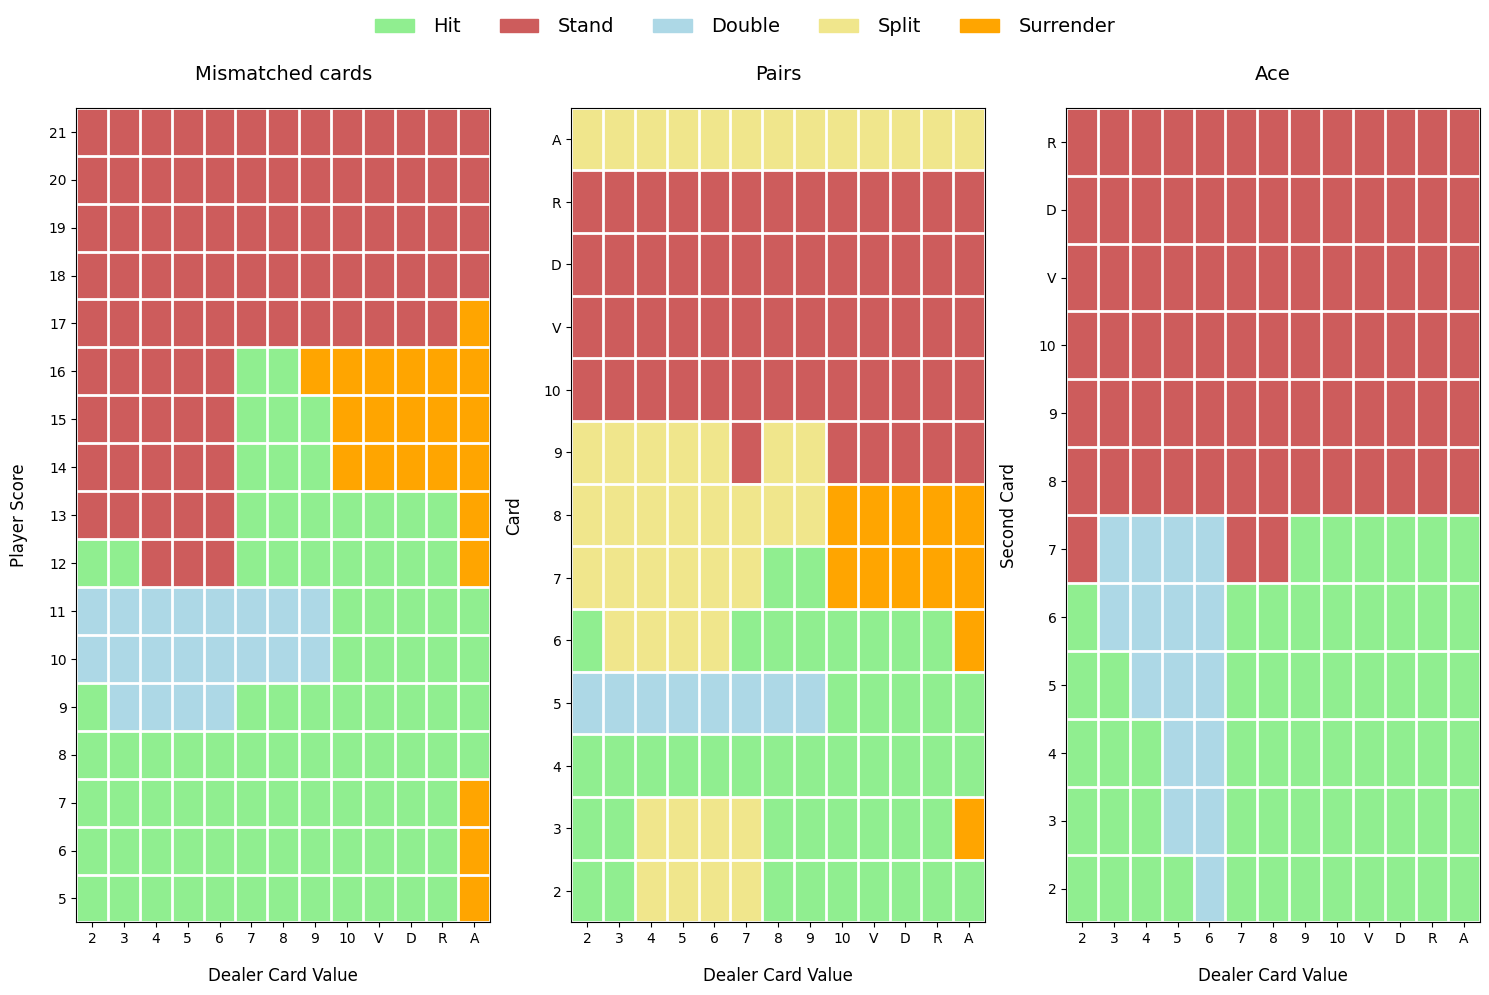

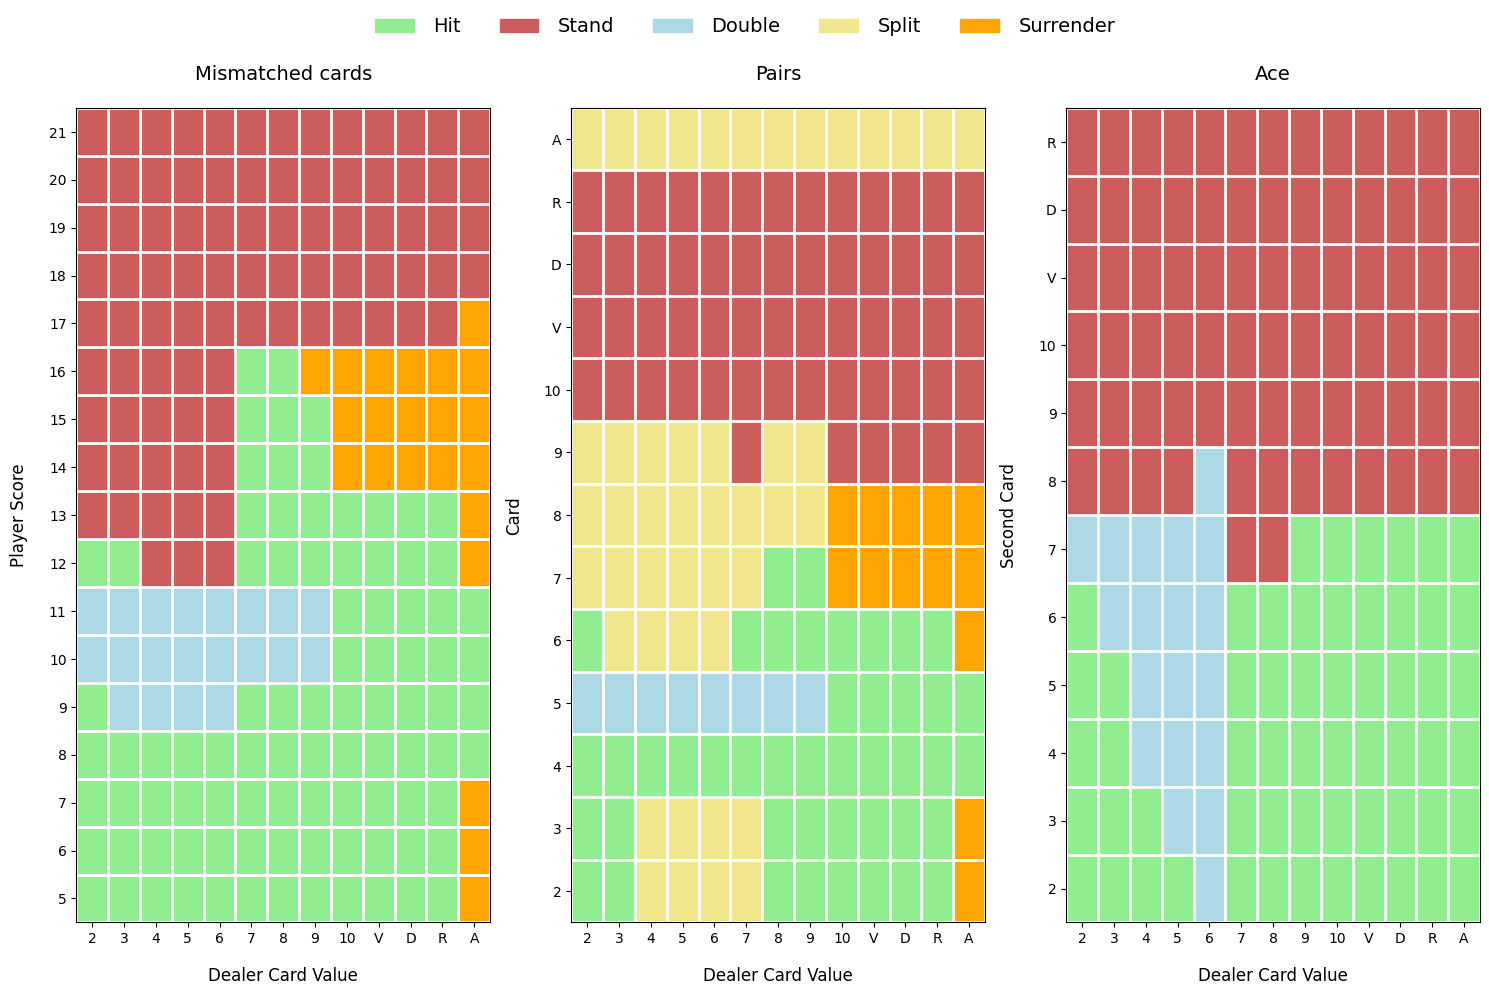

In [104]:
save_image = True
if not os.path.exists("images"):
	os.makedirs("images")
plot_policy_results(playerPolicyOptimalMulti, save=save_image, filename="images/playerPolicyOptimalMulti.png")
plot_policy_results(playerPolicyOptimalMulti17Hard, save=save_image, filename="images/playerPolicyOptimal17HardMulti.png")
plot_policy_results(playerPolicyOptimalMulti17Soft, save=save_image, filename="images/playerPolicyOptimal17SoftMulti.png")

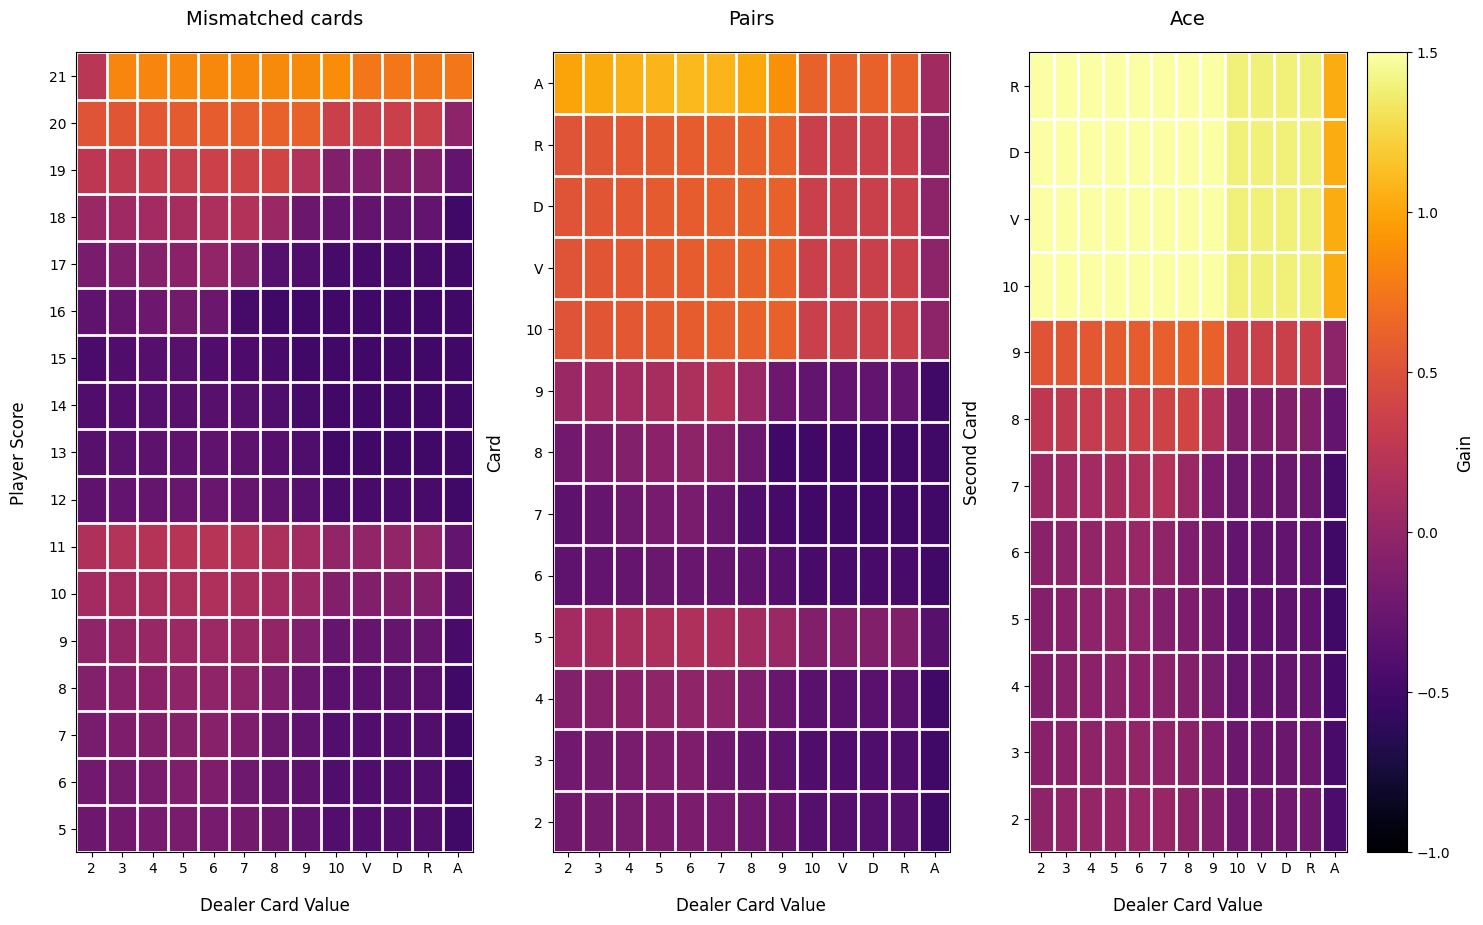

In [105]:
plot_gain_results(playerGainOptimalMulti, save=save_image, filename="images/playerGainOptimalMulti.png")

In [106]:
def playerPolicyWiki(hand_player: Hand, card_dealer: Card) -> Action:
	"""
	Player policy from the wikipedia page
	"""
	card_dealer += 1
	hand = np.array(hand_player)
	num_cards = np.sum(hand)
	pair = len(np.where(hand == 2)[0]) > 0
	ace = hand[0]
	if num_cards == 2 and pair:
		pair_card = np.where(hand == 2)[0][0] + 1
		if pair_card == 1:
			return SPLIT
		if 10 <= pair_card <= 13:
			return STAND
		if pair_card == 9:
			return STAND if (card_dealer == 7) or (10 <= card_dealer <= 13) or (card_dealer == 1) else SPLIT
		if pair_card == 8:
			return SPLIT
		if pair_card == 7:
			return SPLIT if 2 <= card_dealer <= 7 else HIT
		if pair_card == 6:
			return SPLIT if 2 <= card_dealer <= 6 else HIT
		if pair_card == 5:
			return DOUBLE if 2 <= card_dealer <= 9 else HIT
		if pair_card == 4:
			return SPLIT if 5 <= card_dealer <= 6 else HIT
		else:
			return SPLIT if 2 <= card_dealer <= 7 else HIT
	elif num_cards == 2 and ace == 1:
		other_card = np.where(hand == 1)[0][1] + 1
		if 8 <= other_card <= 13:
			return STAND
		if 7 == other_card:
			return DOUBLE if 3 <= card_dealer <= 6 else STAND if 2 <= card_dealer <= 8 else HIT
		if 6 == other_card:
			return DOUBLE if 3 <= card_dealer <= 6 else HIT
		if 4 <= other_card <= 5:
			return DOUBLE if 4 <= card_dealer <= 6 else HIT
		else:
			return DOUBLE if 5 <= card_dealer <= 6 else HIT
	else:
		score = handScore(hand_player)
		if score >= 17:
			return STAND
		if 13 <= score <= 16:
			return STAND if 2 <= card_dealer <= 6 else HIT
		if score == 12:
			return STAND if 4 <= card_dealer <= 6 else HIT
		if score == 11:
			return DOUBLE if 2 <= card_dealer <= 10 else HIT
		if score == 10:
			return DOUBLE if 2 <= card_dealer <= 9 else HIT
		if score == 9:
			return DOUBLE if 3 <= card_dealer <= 5 else HIT
		else:
			return HIT	

In [107]:
def getPlayerGainMatrixFromPolicy(policy: PlayerPolicy, dealerGainMatrix) -> tuple[np.ndarray, np.ndarray]:
	"""
	Compute the gain matrix for a given player policy
	It consider that 2 actions are possible: hit or stand
	The player policy matrix is also computed and returned
	"""
	gainMatrix = np.zeros((num_hands, 13))
	policyMatrix = np.zeros((num_hands, 13))
	for hand_player_idx in range(num_hands-1, -1, -1):
		hand_player = index_to_valid_hands[hand_player_idx]
		for card_dealer in range(num_cards):
			action = policy(hand_player, card_dealer)

			if action == HIT:
				for new_hand, proba in probaHitList(hand_player):
					gainMatrix[hand_player_idx, card_dealer] += proba * gainMatrix[valid_hands_to_index[new_hand], card_dealer]
				gainMatrix[hand_player_idx, card_dealer] -= probaBurst(hand_player)
			elif action == STAND:
				gainMatrix[hand_player_idx, card_dealer] = -dealerGainMatrix[hand_player_idx, valid_hands_to_index[createHand(card_dealer)]]
			policyMatrix[hand_player_idx, card_dealer] = action
	return gainMatrix, policyMatrix

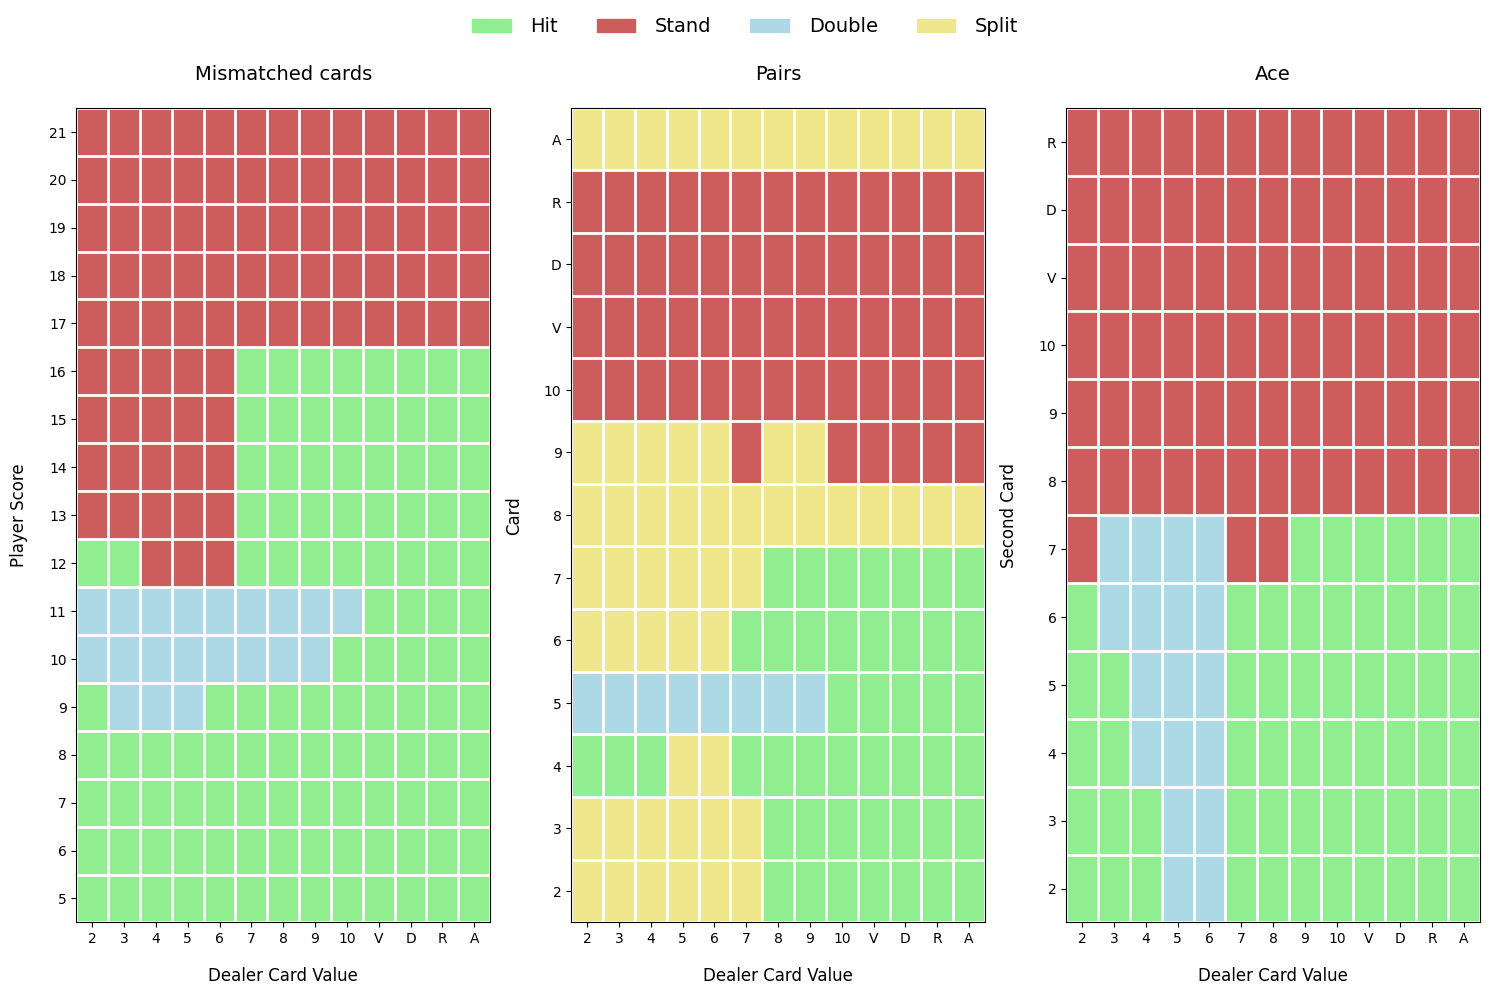

In [108]:
playerGainOptimalWiki, playerPolicyOptimalWiki = getPlayerGainMatrixFromPolicy(playerPolicyWiki, dealerGainOptimal)
playerGain17HardWiki, _ = getPlayerGainMatrixFromPolicy(playerPolicyWiki, dealerGain17Hard)
playerGain17SoftWiki, _ = getPlayerGainMatrixFromPolicy(playerPolicyWiki, dealerGain17Soft)
plot_policy_results(playerPolicyOptimalWiki, save=save_image, filename="images/playerPolicyOptimalWiki.png")

In [109]:
def computePlayerGlobalGain(playerGainMatrix: np.ndarray) -> float:
	"""
	Compute the global gain for the player
	"""
	gain = 0
	for card1_player in card_values:
		for card2_player in card_values:
			for card_dealer in cards:
				gain += playerGainMatrix[valid_hands_to_index[createHand(card1_player, card2_player)], card_dealer] * probaDraw(card1_player) * probaDraw(card2_player) * probaDraw(card_dealer)
	return gain

In [110]:
print(f"Global gain for the player with the optimal policy and dealer optimal: {computePlayerGlobalGain(playerGainOptimalMulti):.3f}")
print(f"Global gain for the player with the optimal policy and dealer stand on 17 hard: {computePlayerGlobalGain(playerGainOptimalMulti17Hard):.3f}")
print(f"Global gain for the player with the optimal policy and dealer stand on 17 soft: {computePlayerGlobalGain(playerGainOptimalMulti17Soft):.3f}")
print("\n")
print(f"Global gain for the player with the wikipedia policy and dealer optimal: {computePlayerGlobalGain(playerGainOptimalWiki):.3f}")
print(f"Global gain for the player with the wikipedia policy and dealer stand on 17 hard: {computePlayerGlobalGain(playerGain17HardWiki):.3f}")
print(f"Global gain for the player with the wikipedia policy and dealer stand on 17 soft: {computePlayerGlobalGain(playerGain17SoftWiki):.3f}")

Global gain for the player with the optimal policy and dealer optimal: -0.152
Global gain for the player with the optimal policy and dealer stand on 17 hard: -0.067
Global gain for the player with the optimal policy and dealer stand on 17 soft: -0.069


Global gain for the player with the wikipedia policy and dealer optimal: -0.214
Global gain for the player with the wikipedia policy and dealer stand on 17 hard: -0.102
Global gain for the player with the wikipedia policy and dealer stand on 17 soft: -0.104
